# Visual and Data Analytics Coursework II Notebook
## Utkrista Acharya 24040294
## Sushma Chaudhary 24040296

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Import necessary libraries


In [7]:
import pandas as pd
import numpy as np
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.subplots as sp
import plotly.graph_objects as go
import pandas as pd
import plotly.express as px
import requests

# Loading the dataset


In [8]:
file_path = '/content/drive/MyDrive/VDAPart2/FIR_Details_Data.csv'  # Replace with the dataset path
data = pd.read_csv(file_path,low_memory=False)

In [9]:
# Display the first few rows and check columns
print("Dataset Loaded Successfully!")
print("Columns in the dataset:")
print(data.columns)
# Basic Descriptive Statistics
print(data.describe())


Dataset Loaded Successfully!
Columns in the dataset:
Index(['District_Name', 'UnitName', 'FIR_YEAR', 'FIR_MONTH',
       'Offence_Duration', 'FIR_Day', 'FIR Type', 'FIR_Stage',
       'Complaint_Mode', 'CrimeGroup_Name', 'CrimeHead_Name', 'Latitude',
       'Longitude', 'ActSection', 'IOName', 'KGID', 'Internal_IO',
       'Place of Offence', 'Distance from PS', 'Beat_Name',
       'Village_Area_Name', 'Male', 'Female', 'Boy', 'Girl', 'Age 0',
       'VICTIM COUNT', 'Accused Count', 'Arrested Male', 'Arrested Female',
       'Arrested Count\tNo.', 'Accused_ChargeSheeted Count',
       'Conviction Count', 'Unit_ID'],
      dtype='object')
           FIR_YEAR     FIR_MONTH  Offence_Duration       FIR_Day  \
count  1.674734e+06  1.674734e+06      1.674734e+06  1.674734e+06   
mean   2.019501e+03  6.266358e+00      7.452927e+01  1.563677e+01   
std    2.469925e+00  3.450955e+00      5.432032e+02  8.836198e+00   
min    2.016000e+03  1.000000e+00     -3.240000e+02  1.000000e+00   
25%    2.

In [10]:
# Filter records where `fir_year` is between 2020 and 2024
if 'FIR_YEAR' in data.columns:
    filtered_data = data[(data['FIR_YEAR'] >= 2020) & (data['FIR_YEAR'] <= 2024)].copy()
    print("Filtered data shape:", filtered_data.shape)
else:
    print("Error: 'fir_year' column not found in the dataset.")
    raise KeyError("'fir_year' column is required for filtering.")


Filtered data shape: (805245, 34)


In [11]:
# Preprocessing on the filtered dataset
# Check and handle duplicates
duplicates = filtered_data.duplicated().sum()
print("\nNumber of duplicate rows:", duplicates)
filtered_data = filtered_data.drop_duplicates()
print("Duplicates removed. Remaining rows:", filtered_data.shape[0])


Number of duplicate rows: 4350
Duplicates removed. Remaining rows: 800895


In [12]:
# Handle missing values
print("\nMissing Values in Filtered Data (before filling):")
print(filtered_data.isnull().sum())


Missing Values in Filtered Data (before filling):
District_Name                       0
UnitName                            0
FIR_YEAR                            0
FIR_MONTH                           0
Offence_Duration                    0
FIR_Day                             0
FIR Type                            0
FIR_Stage                           0
Complaint_Mode                      0
CrimeGroup_Name                     0
CrimeHead_Name                      0
Latitude                       436434
Longitude                      436437
ActSection                          0
IOName                              0
KGID                                0
Internal_IO                         0
Place of Offence                    0
Distance from PS                    0
Beat_Name                           0
Village_Area_Name                   0
Male                                0
Female                              0
Boy                                 0
Girl                                0

In [13]:
# Rename features to match geojson district map names as cleaning step
filtered_data['District_Name'] = filtered_data['District_Name'].replace({
    'Bengaluru City': 'Bengaluru Urban',
    'Belagavi Dist': 'Belagavi',
    'Bengaluru Dist': 'Bengaluru Rural',
    'Bagalkot': 'Bagalkote',
    'Chamarajanagar': 'Chamarajanagara',
    'Belagavi City': 'Belagavi',
    'Chickballapura': 'Chikkaballapura',
    'Mysuru City': 'Mysuru',
    'Vijayanagara': 'Vijayapura',
    'Kalaburagi City': 'Kalaburagi',
    'Hubballi Dharwad City': 'Dharwad',
    'Vijayapur':'Vijayapura'
})

print("District names renamed to match geojson district map names to be usable later as a base map for geo-spatial analysis.")

District names renamed to match geojson district map names to be usable later as a base map for geo-spatial analysis.


In [14]:
filtered_data.District_Name.unique()

array(['Bagalkote', 'Ballari', 'Belagavi', 'Bengaluru Urban',
       'Bengaluru Rural', 'Bidar', 'Chamarajanagara', 'Chikkaballapura',
       'Chikkamagaluru', 'Chitradurga', 'CID', 'Coastal Security Police',
       'Dakshina Kannada', 'Davanagere', 'Dharwad', 'Gadag', 'Hassan',
       'Haveri', 'ISD Bengaluru', 'K.G.F', 'Kalaburagi',
       'Karnataka Railways', 'Kodagu', 'Kolar', 'Koppal', 'Mandya',
       'Mangaluru City', 'Mysuru', 'Mysuru Dist', 'Raichur', 'Ramanagara',
       'Shivamogga', 'Tumakuru', 'Udupi', 'Uttara Kannada', 'Vijayapura',
       'Yadgir'], dtype=object)

In [15]:
# Define the function to fill missing Latitude and Longitude
def fill_missing_spatial(group):
    # Forward and backward fill within each group
    group['Latitude'] = group['Latitude'].ffill().bfill()
    group['Longitude'] = group['Longitude'].ffill().bfill()
    return group

# Group by 'District_Name' and apply the filling function, keeping 'District_Name'
filtered_data = filtered_data.groupby('District_Name', group_keys=False).apply(fill_missing_spatial)

# Confirm no missing values remain in Latitude and Longitude
print("\nMissing Values in Latitude and Longitude (after filling):")
print(filtered_data[['Latitude', 'Longitude']].isnull().sum())


Missing Values in Latitude and Longitude (after filling):
Latitude     16
Longitude    16
dtype: int64


<ipython-input-15-f01528fc97fb>:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  filtered_data = filtered_data.groupby('District_Name', group_keys=False).apply(fill_missing_spatial)


In [16]:
filtered_data = filtered_data.dropna(subset=['Latitude', 'Longitude'])
print("\nRemaining rows with missing spatial data removed: ", filtered_data.shape[0])


Remaining rows with missing spatial data removed:  800879


In [17]:
filtered_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 800879 entries, 711 to 1674733
Data columns (total 34 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   District_Name                800879 non-null  object 
 1   UnitName                     800879 non-null  object 
 2   FIR_YEAR                     800879 non-null  int64  
 3   FIR_MONTH                    800879 non-null  int64  
 4   Offence_Duration             800879 non-null  int64  
 5   FIR_Day                      800879 non-null  int64  
 6   FIR Type                     800879 non-null  object 
 7   FIR_Stage                    800879 non-null  object 
 8   Complaint_Mode               800879 non-null  object 
 9   CrimeGroup_Name              800879 non-null  object 
 10  CrimeHead_Name               800879 non-null  object 
 11  Latitude                     800879 non-null  float64
 12  Longitude                    800879 non-null  float64
 13  A

In [18]:
# Check for infinite values in the entire dataset
inf_check = filtered_data.isin([np.inf, -np.inf]).sum()

# Display columns with infinite values
print("Number of infinite values in each column:")
print(inf_check)

# Confirm if there are any infinite values in the dataset
if inf_check.sum() > 0:
    print("\nInfinite values found in the dataset.")
else:
    print("\nNo infinite values found in the dataset.")

Number of infinite values in each column:
District_Name                  0
UnitName                       0
FIR_YEAR                       0
FIR_MONTH                      0
Offence_Duration               0
FIR_Day                        0
FIR Type                       0
FIR_Stage                      0
Complaint_Mode                 0
CrimeGroup_Name                0
CrimeHead_Name                 0
Latitude                       0
Longitude                      0
ActSection                     0
IOName                         0
KGID                           0
Internal_IO                    0
Place of Offence               0
Distance from PS               0
Beat_Name                      0
Village_Area_Name              0
Male                           0
Female                         0
Boy                            0
Girl                           0
Age 0                          0
VICTIM COUNT                   0
Accused Count                  0
Arrested Male                  0
A

In [19]:
# Display summary of preprocessed data
print("\nPreprocessed Data Summary:")
print(filtered_data.info())


Preprocessed Data Summary:
<class 'pandas.core.frame.DataFrame'>
Index: 800879 entries, 711 to 1674733
Data columns (total 34 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   District_Name                800879 non-null  object 
 1   UnitName                     800879 non-null  object 
 2   FIR_YEAR                     800879 non-null  int64  
 3   FIR_MONTH                    800879 non-null  int64  
 4   Offence_Duration             800879 non-null  int64  
 5   FIR_Day                      800879 non-null  int64  
 6   FIR Type                     800879 non-null  object 
 7   FIR_Stage                    800879 non-null  object 
 8   Complaint_Mode               800879 non-null  object 
 9   CrimeGroup_Name              800879 non-null  object 
 10  CrimeHead_Name               800879 non-null  object 
 11  Latitude                     800879 non-null  float64
 12  Longitude                    800

In [20]:
# Creating FIR_DATE column from FIR_YEAR, FIR_MONTH, FIR_DAY
if all(col in filtered_data.columns for col in ['FIR_YEAR', 'FIR_MONTH', 'FIR_Day']):
    # Combine the columns into a single date column
    filtered_data['FIR_DATE'] = pd.to_datetime(
        filtered_data[['FIR_YEAR', 'FIR_MONTH', 'FIR_Day']].astype(str).agg('-'.join, axis=1),
        format='%Y-%m-%d'
    )
    print("FIR_DATE column created successfully!")
else:
    print("One or more of the columns FIR_YEAR, FIR_MONTH, FIR_DAY are missing.")

FIR_DATE column created successfully!


In [21]:
# Add the 'day_of_week' feature from 'FIR_DATE'
if 'FIR_DATE' in filtered_data.columns:
    filtered_data['FIR_DATE'] = pd.to_datetime(filtered_data['FIR_DATE'], format='%Y-%m-%d')
    filtered_data['day_of_week'] = filtered_data['FIR_DATE'].dt.day_name()  # Extract day of the week
    print("Feature 'day_of_week' added successfully!")
else:
    print("Error: 'FIR_DATE' column not found in the dataset.")

# Display columns after modifications
print("\nColumns after modifications:")
print(filtered_data.columns)


Feature 'day_of_week' added successfully!

Columns after modifications:
Index(['District_Name', 'UnitName', 'FIR_YEAR', 'FIR_MONTH',
       'Offence_Duration', 'FIR_Day', 'FIR Type', 'FIR_Stage',
       'Complaint_Mode', 'CrimeGroup_Name', 'CrimeHead_Name', 'Latitude',
       'Longitude', 'ActSection', 'IOName', 'KGID', 'Internal_IO',
       'Place of Offence', 'Distance from PS', 'Beat_Name',
       'Village_Area_Name', 'Male', 'Female', 'Boy', 'Girl', 'Age 0',
       'VICTIM COUNT', 'Accused Count', 'Arrested Male', 'Arrested Female',
       'Arrested Count\tNo.', 'Accused_ChargeSheeted Count',
       'Conviction Count', 'Unit_ID', 'FIR_DATE', 'day_of_week'],
      dtype='object')


In [22]:
# Display columns before modifications
print("Columns before modifications:")
print(filtered_data.columns)

# Remove unnecessary columns
columns_to_remove = [
    'KGID', 'Internal_IO', 'Place of Offence', 'ActSection', 'Unit_ID', 'Offence_Duration']
filtered_data = filtered_data.drop(columns=columns_to_remove, errors='ignore')


Columns before modifications:
Index(['District_Name', 'UnitName', 'FIR_YEAR', 'FIR_MONTH',
       'Offence_Duration', 'FIR_Day', 'FIR Type', 'FIR_Stage',
       'Complaint_Mode', 'CrimeGroup_Name', 'CrimeHead_Name', 'Latitude',
       'Longitude', 'ActSection', 'IOName', 'KGID', 'Internal_IO',
       'Place of Offence', 'Distance from PS', 'Beat_Name',
       'Village_Area_Name', 'Male', 'Female', 'Boy', 'Girl', 'Age 0',
       'VICTIM COUNT', 'Accused Count', 'Arrested Male', 'Arrested Female',
       'Arrested Count\tNo.', 'Accused_ChargeSheeted Count',
       'Conviction Count', 'Unit_ID', 'FIR_DATE', 'day_of_week'],
      dtype='object')


# Feature Renaming to avoid confusions

In [23]:
# Renaming and Standardize columns for removing confusion
rename_columns = {
    'Age 0': 'Infant Victim',
    'Boy': 'Boy Victim',
    'Girl': 'Girl Victim',
    'Male': 'Male Victim',
    'Female': 'Female Victim',
    'Arrested Count\tNo.':'Arrested Count'

}

# Apply the renaming
filtered_data.rename(columns=rename_columns, inplace=True)

# Display updated column names
print("Updated Column Names:")
print(filtered_data.columns)

Updated Column Names:
Index(['District_Name', 'UnitName', 'FIR_YEAR', 'FIR_MONTH', 'FIR_Day',
       'FIR Type', 'FIR_Stage', 'Complaint_Mode', 'CrimeGroup_Name',
       'CrimeHead_Name', 'Latitude', 'Longitude', 'IOName', 'Distance from PS',
       'Beat_Name', 'Village_Area_Name', 'Male Victim', 'Female Victim',
       'Boy Victim', 'Girl Victim', 'Infant Victim', 'VICTIM COUNT',
       'Accused Count', 'Arrested Male', 'Arrested Female', 'Arrested Count',
       'Accused_ChargeSheeted Count', 'Conviction Count', 'FIR_DATE',
       'day_of_week'],
      dtype='object')


In [24]:
filtered_data.shape

(800879, 30)

In [25]:
# Sort the dataset by FIR_DATE (ascending order)
if 'FIR_DATE' in filtered_data.columns:
    filtered_data = filtered_data.sort_values(by='FIR_DATE', ascending=True)
    print("Dataset sorted by FIR_DATE in ascending order.")
else:
    print("Error: 'FIR_DATE' column not found in the dataset.")

# Save the sorted dataset
output_path = '/content/drive/MyDrive/VDA Group 4/fir_data_2020_2024_cleaned.csv'
filtered_data.to_csv(output_path, index=False)
print(f"Sorted dataset saved successfully at: {output_path}")

Dataset sorted by FIR_DATE in ascending order.
Sorted dataset saved successfully at: /content/drive/MyDrive/VDA Group 4/fir_data_2020_2024_cleaned.csv


In [26]:
cleaned_data=filtered_data

In [27]:
filtered_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 800879 entries, 138111 to 601469
Data columns (total 30 columns):
 #   Column                       Non-Null Count   Dtype         
---  ------                       --------------   -----         
 0   District_Name                800879 non-null  object        
 1   UnitName                     800879 non-null  object        
 2   FIR_YEAR                     800879 non-null  int64         
 3   FIR_MONTH                    800879 non-null  int64         
 4   FIR_Day                      800879 non-null  int64         
 5   FIR Type                     800879 non-null  object        
 6   FIR_Stage                    800879 non-null  object        
 7   Complaint_Mode               800879 non-null  object        
 8   CrimeGroup_Name              800879 non-null  object        
 9   CrimeHead_Name               800879 non-null  object        
 10  Latitude                     800879 non-null  float64       
 11  Longitude                 

# Exploratory Analysis after Preprocessing Techniques Applied

## WORD Cloud to visualize text based repeatations of the most prominent crime reported in FIR

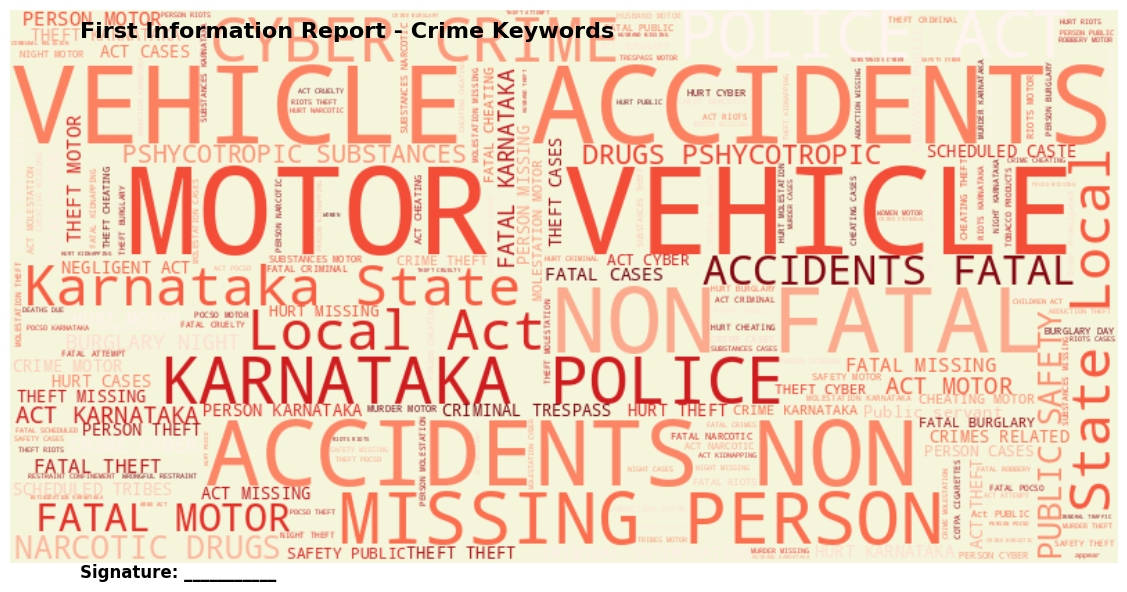

In [28]:
# Import necessary libraries
from wordcloud import WordCloud
import matplotlib.pyplot as plt
# Combine all text into a single string
text_data = " ".join(filtered_data['CrimeGroup_Name'].dropna())

# Generate word cloud with FIR-like aesthetics
wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='beige',  # FIR-style document background
    colormap='Reds',  # Crime-related color scheme
    contour_width=2,
    contour_color='black'
).generate(text_data)

# Plot the styled word cloud
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')

# Adding FIR-like textual elements
plt.text(50, 20, "First Information Report - Crime Keywords", fontsize=16, fontweight='bold', color='black')
plt.text(50, 410, "Signature: ___________", fontsize=12, fontweight='bold', color='black')

plt.tight_layout()
plt.show()

## WORD Cloud to visualize text based repeatations of the most preferred way or mode of FIR reporting by the witness or victim

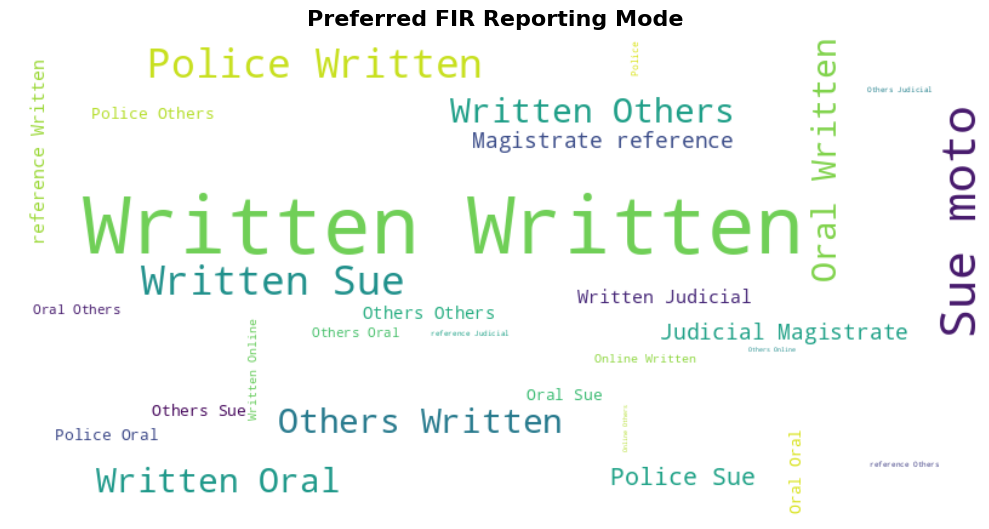

In [29]:
# Import necessary libraries
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Combine all the text in the Complaint_Mode column into a single string
text_data = " ".join(filtered_data['Complaint_Mode'].dropna())

# Generate the word cloud
wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    colormap='viridis',
    contour_width=1,  # Reduced contour width for a subtler effect
    contour_color='steelblue',
    normalize_plurals=True  # Normalize words with plurals for consistency
).generate(text_data)

# Plot the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Hide axes for a cleaner look
plt.title("Preferred FIR Reporting Mode", fontsize=16, fontweight='bold')
plt.tight_layout()

plt.show()  # Display the plot
plt.close()  # Close the plot after saving

# Crime Frequency by Top 10 Districts


<ipython-input-30-0f3496725299>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=district_counts.values, y=district_counts.index, palette='magma')  # 'magma' color palette for bold visuals


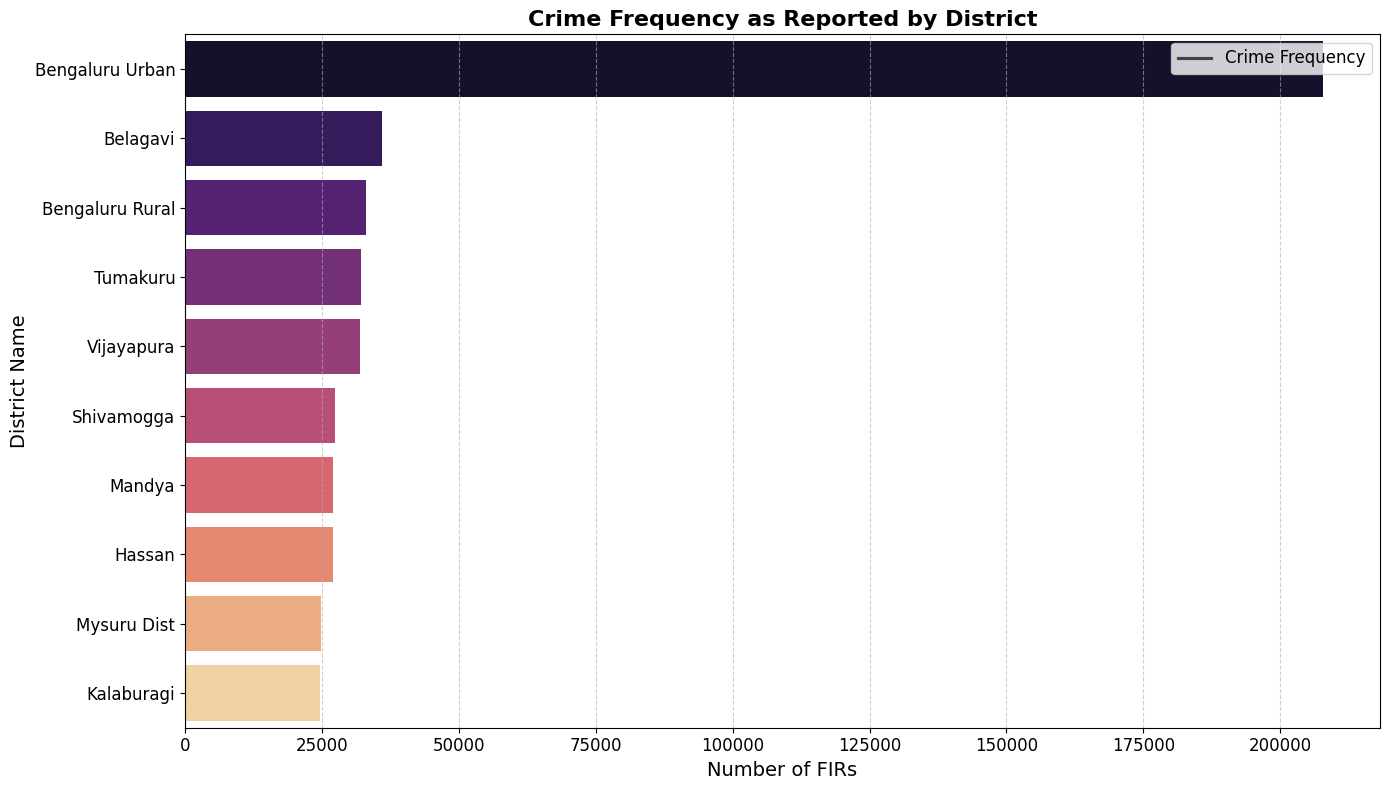

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(14, 8))
district_counts = filtered_data['District_Name'].value_counts().head(10)
sns.barplot(x=district_counts.values, y=district_counts.index, palette='magma')  # 'magma' color palette for bold visuals
plt.title("Crime Frequency as Reported by District", fontsize=16, fontweight='bold')
plt.xlabel("Number of FIRs", fontsize=14)
plt.ylabel("District Name", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(['Crime Frequency'], loc='upper right', fontsize=12)  # Adding legend for clarity
plt.grid(axis='x', linestyle='--', alpha=0.6)  # Gridlines for readability
plt.tight_layout()
plt.show()

# Crime Trends Over Time with identifiable features
---

### **Visualization: Crime Analysis with Subplots**

This visualization combines two insightful plots to analyze crime data from 2020 to 2024:
a **line plot** capturing crime trends over time and a **histogram** showing the distribution of crime counts.

---

### **Key Features**

#### 1. **Line Plot: Crime Trends Over Time**
- **Purpose**:
  - Visualizes how crime trends have changed on a daily basis between 2020 and 2024.
  
- **Details**:
  - **X-axis**: Displays dates (FIR filing dates).
  - **Y-axis**: Represents the number of FIRs filed each day.
  - **Color Scheme**: A sleek blue line (`dodgerblue`) makes the trends easy to follow.
  - **Markers**: Highlight specific data points for clarity.
  - **Gridlines**: Enhance readability with dashed gridlines for visual alignment.
  - **Legend**: Label the trend line to indicate the data source ("Crime Count").

#### 2. **Histogram: Distribution of Crime Counts**
- **Purpose**:
  - Analyzes the frequency of FIR counts over the given time frame.
  
- **Details**:
  - **X-axis**: Displays ranges of FIR counts.
  - **Y-axis**: Represents the frequency of occurrence.
  - **Bins**: Divides the data into 20 intervals for clearer distribution.
  - **Color Scheme**: Coral-colored bars make the visualization vibrant.
  - **KDE Curve**: A Kernel Density Estimate line overlays the histogram to indicate the distribution's shape.

---

#### 3. **Combined Layout**
- **Figure Dimensions**:
  - The subplots are displayed in a figure sized at 18x8 inches to maximize clarity.
  - The **line plot** occupies a larger space (2:1 width ratio) for detailed trend analysis.

- **Alignment**:
  - A **tight layout** ensures optimal spacing and alignment between the subplots.
  
- **Aesthetic Enhancements**:
  - Titles, labels, and font sizes are customized for better readability.
  - The x-axis ticks in the line plot are rotated (`45°`) for a neat display of date labels.

---

### **Purpose**
This dual visualization helps uncover:
- The **crime trends** over a specific time period, enabling better understanding of daily fluctuations.
- The **distribution of FIR counts**, offering insights into common and extreme reporting patterns.

---

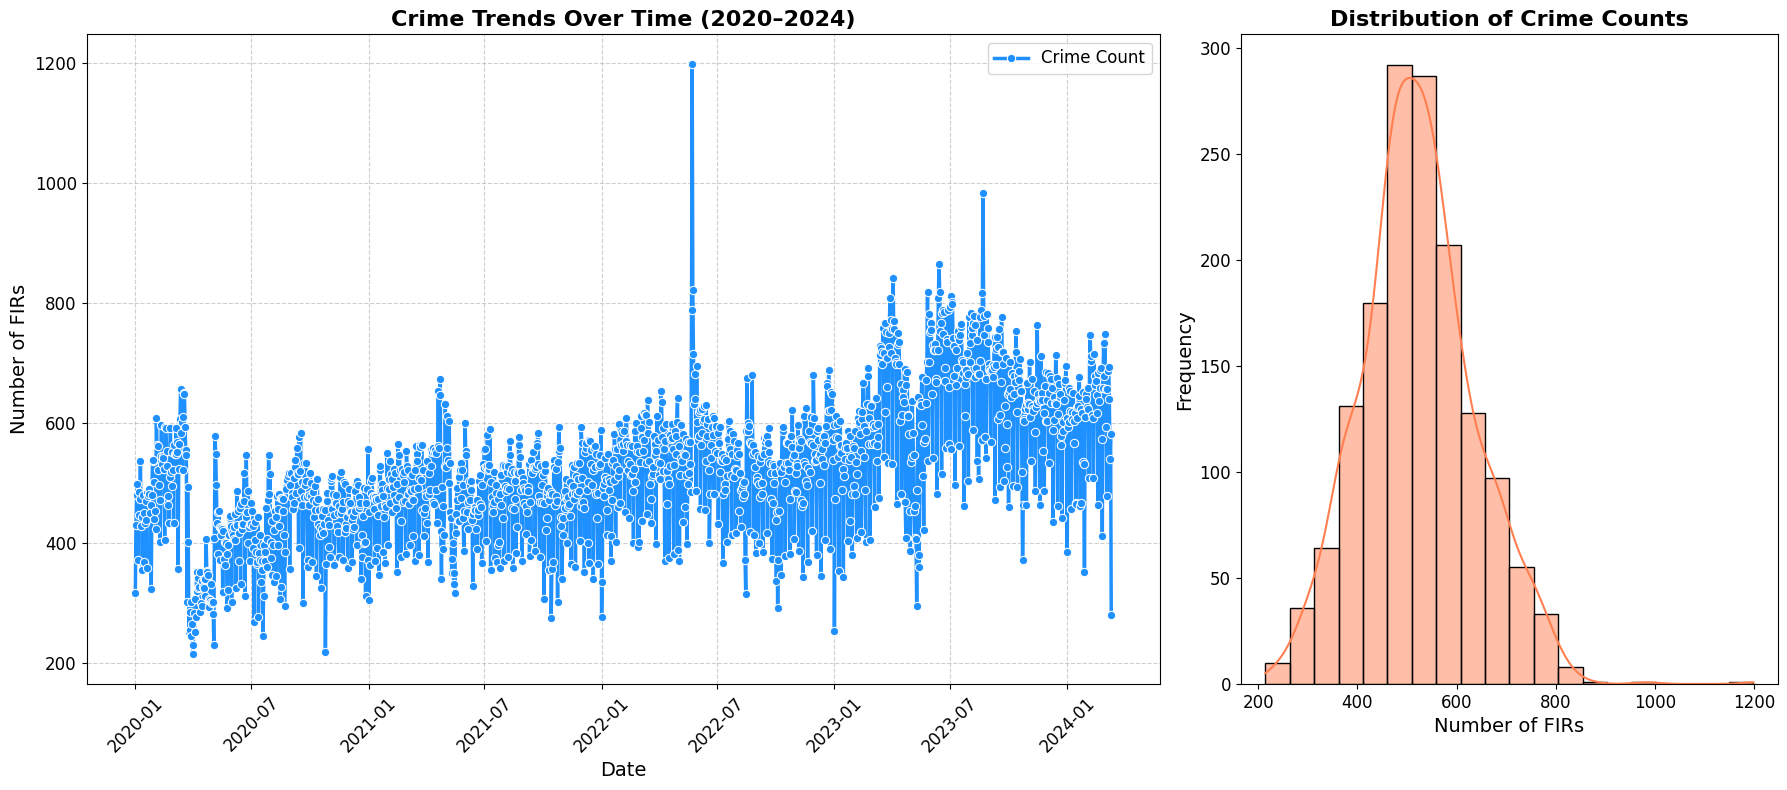

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

# Data preparation
crime_counts = filtered_data.groupby('FIR_DATE').size()

# Create the figure with subplots
fig, axes = plt.subplots(1, 2, figsize=(18, 8), gridspec_kw={'width_ratios': [2, 1]})  # Wider line plot on the left

# Line Plot (Crime Trends)
sns.lineplot(
    ax=axes[0],
    x=crime_counts.index,
    y=crime_counts.values,
    color='dodgerblue',
    linewidth=2.5,
    marker='o',
    label='Crime Count'
)
axes[0].set_title("Crime Trends Over Time (2020–2024)", fontsize=16, fontweight='bold')
axes[0].set_xlabel("Date", fontsize=14)
axes[0].set_ylabel("Number of FIRs", fontsize=14)
axes[0].tick_params(axis='x', rotation=45, labelsize=12)
axes[0].tick_params(axis='y', labelsize=12)
axes[0].legend(fontsize=12)
axes[0].grid(linestyle='--', alpha=0.6)

# Histogram (Crime Distribution)
sns.histplot(
    ax=axes[1],
    x=crime_counts.values,
    bins=20,
    color='coral',
    kde=True,  # Adds a Kernel Density Estimate line
)
axes[1].set_title("Distribution of Crime Counts", fontsize=16, fontweight='bold')
axes[1].set_xlabel("Number of FIRs", fontsize=14)
axes[1].set_ylabel("Frequency", fontsize=14)
axes[1].tick_params(axis='x', labelsize=12)
axes[1].tick_params(axis='y', labelsize=12)

# Tight layout for proper spacing
plt.tight_layout()
plt.show()

### Visualization : Crime Frequency by Day of the Week

**Purpose**:  
This interactive bar chart highlights the frequency of crimes reported (`FIRs`) on each day of the week, offering insights into daily patterns in crime occurrences. The visualization can aid law enforcement agencies and policymakers in optimizing resource allocation based on weekly crime trends.

**Key Variables**:  
- **X-axis**: Day of the Week (`day_of_week`)  
- **Y-axis**: Number of FIRs (`Number of FIRs`)  
- **Color Gradient**: Represents FIR count, using the Viridis color scale for variation.  
- **Hover Information**: Displays the exact FIR count for each day of the week.  

**Key Insights**:  
- **Daily Trends**: Identifies days with higher crime frequency (e.g., peaks on weekends or specific weekdays).  
- **Resource Allocation**: Helps focus resources on days with higher activity (e.g., increased patrols on Saturday/Sunday).  
- **Crime Management**: Reveals patterns that can inform proactive strategies, such as deploying surveillance or reinforcing personnel during peak times.  

**Visual Features**:  
- **Gradient Color Scheme**: The Viridis palette provides a visually appealing range, emphasizing variations in FIR counts.  
- **Categorical Sorting**: Ensures the days are correctly ordered (Monday to Sunday) for intuitive readability.  
- **Light Background**: Makes the chart clean and easy to interpret.  

**Interactivity**:  
- **Hover Details**: Explore FIR counts for each day of the week to examine daily crime patterns.  
- **Dynamic Color Scaling**: Observe how FIR counts vary through a continuous color gradient.  

This visualization offers a straightforward and engaging way to understand crime trends across the week, making it useful for operational planning and strategic decision-making.

In [32]:
import plotly.express as px
import pandas as pd

# Calculate counts of crimes by day of the week
day_counts = filtered_data['day_of_week'].value_counts()
day_counts = day_counts.reset_index()
day_counts.columns = ['Day of Week', 'Number of FIRs']

# Sort days of the week to align properly (optional, depending on your dataset)
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
day_counts['Day of Week'] = pd.Categorical(day_counts['Day of Week'], categories=day_order, ordered=True)
day_counts = day_counts.sort_values('Day of Week')

# Create the interactive bar chart
fig = px.bar(
    day_counts,
    x='Day of Week',
    y='Number of FIRs',
    color='Number of FIRs',  # Color variations based on the FIR count
    color_continuous_scale='Viridis',  # Gradient color scheme
    title='Crime Frequency by Day of the Week',
    labels={'Number of FIRs': 'Number of FIRs', 'Day of Week': 'Day of the Week'},  # Axis labels
    height=600
)

# Add tooltips and interactivity
fig.update_traces(hovertemplate="<b>%{x}</b><br>FIRs: %{y}<extra></extra>")
fig.update_layout(
    title_font=dict(size=18, color='darkblue', family='Arial Black'),
    xaxis=dict(title_font=dict(size=14), tickfont=dict(size=12)),
    yaxis=dict(title_font=dict(size=14), tickfont=dict(size=12)),
    coloraxis_colorbar=dict(title="FIR Count"),
    plot_bgcolor='rgba(245, 245, 250, 1)',  # Light background
)

# Show the interactive plot
fig.show()

### Visualization: Top Crime Types in Bengaluru Urban

**Purpose**:  
These visualizations showcase the most prevalent crime types in the Bengaluru Urban district. By displaying a bar chart and a pie (donut-style) chart, they provide a clear overview of the crime landscape, highlighting which crime categories require immediate attention.

**Key Variables**:  
- **X-axis (Bar Chart)**: Crime Type (`CrimeGroup_Name`)  
- **Y-axis (Bar Chart)**: Number of Cases (`Count`)  
- **Pie Chart Segments**: Crime types represented proportionally based on the number of cases.  
- **Hover Information**: Displays the crime type and the exact number of cases for detailed exploration.

**Key Insights**:  
- **High-Impact Crimes**: Identifies which crime types dominate in Bengaluru Urban.  
- **Proportional View**: The pie chart provides a percentage-based perspective on the crime distribution.  
- **Actionable Data**: Useful for policymakers and law enforcement to prioritize efforts on addressing specific crime types with the highest prevalence.

**Visual Features**:  
- **Bar Chart**:  
  - Each crime type is color-coded for easy differentiation.  
  - Displays exact case numbers on each bar for quick reference.  
  - Interactive hover details provide additional clarity.  
- **Pie Chart**:  
  - Donut-style format with a `Plasma` color scheme for better visual appeal.  
  - Clearly represents the proportion of each crime category in the total dataset.  

**Interactivity**:  
- **Bar Chart**: Explore crime types by hovering over bars for detailed information.  
- **Pie Chart**: Hover over slices to reveal percentages and case counts.  

These visualizations collectively provide a comprehensive understanding of crime types in Bengaluru Urban, enabling data-driven decision-making.

In [33]:
import plotly.express as px
import pandas as pd

# Top 10 Crime Types grouped by districts
top_crime_types_districts = filtered_data.groupby(['CrimeGroup_Name', 'District_Name']).size().reset_index(name='Count')
top_crime_types = filtered_data['CrimeGroup_Name'].value_counts().head(10).index

# Filter data to only include the top crime types
filtered_top_crime_types = top_crime_types_districts[top_crime_types_districts['CrimeGroup_Name'].isin(top_crime_types)]

# Filter data for Bengaluru Urban district
bengaluru_data = filtered_top_crime_types[filtered_top_crime_types['District_Name'] == 'Bengaluru Urban']

# Bar Chart: Top Crime Types in Bengaluru Urban
fig_bar = px.bar(
    bengaluru_data,
    x='CrimeGroup_Name',
    y='Count',
    color='CrimeGroup_Name',  # Assign distinct colors for each crime type
    title="Top Crime Types in Bengaluru Urban (Bar Chart)",
    labels={'CrimeGroup_Name': 'Crime Type', 'Count': 'Number of Cases'},
    text_auto=True,  # Display values on bars
    height=600,
    width=1000
)

# Update hover template for detailed information in bar chart
fig_bar.update_traces(
    hovertemplate="<b>Crime Type:</b> %{x}<br><b>Number of Cases:</b> %{y}<extra></extra>"
)

# Update layout for bar chart aesthetics
fig_bar.update_layout(
    xaxis_title='Crime Type',
    yaxis_title='Number of Cases',
    legend_title='Crime Type',
    title_x=0.5,
    font=dict(size=14),
    template='plotly_white',
    showlegend=True  # Display legend for crime types
)

# Pie Chart: Top Crime Types in Bengaluru Urban
fig_pie = px.pie(
    bengaluru_data,
    names='CrimeGroup_Name',
    values='Count',
    title="Top Crime Types in Bengaluru Urban (Pie Chart)",
    color_discrete_sequence=px.colors.sequential.Plasma,  # Color scheme for better distinction
    hole=0.4  # Creates a donut-style chart
)

# Update layout for pie chart aesthetics
fig_pie.update_layout(
    title_x=0.5,
    font=dict(size=14),
    template='plotly_white'
)

# Display both charts
fig_bar.show()
fig_pie.show()

# FIR Registration Type, Distribution of Crimes into Heinous and Non Heinous Category
---

### **Visualization: Doughnut Chart for FIR Type Distribution**

This visualization provides insights into the distribution of **FIR Types** (e.g., Heinous and Non-Heinous crimes) using a clean, interactive **doughnut chart**.

---

### **Key Features**

#### 1. **Data Preparation**
- **FIR Type Grouping**:
  - Data is grouped by **FIR Type**, and the count of FIRs is calculated for each type.
  - Example FIR Types: **Heinous** and **Non-Heinous**.

- **Custom Color Mapping**:
  - Assigns distinct colors to FIR Types for clear differentiation:
    - **Red** for Heinous crimes.
    - **Blue** for Non-Heinous crimes.

#### 2. **Doughnut Chart**
- **Structure**:
  - Created using `px.pie` with the `hole=0.4` parameter to achieve a **doughnut shape**.
  
- **Data Representation**:
  - Segments of the doughnut represent FIR counts for each type, making the proportions visually intuitive.

- **Custom Colors**:
  - Leverages the `color_discrete_map` option to apply the red-blue color scheme.

---

#### 3. **Improved Aesthetic Layout**
- **Title**:
  - The chart includes a centered title: *"FIR Type Distribution"*.
  
- **Legend**:
  - A horizontal legend positioned below the chart provides a clear mapping of colors to FIR Types.
  - Example settings:
    - **Position**: Below the chart using `y=-0.2`.
    - **Centered**: Legend is horizontally aligned.

- **Styling**:
  - Clean, modern visual style applied with `plotly_white`.
  - Optimized font size for better readability.

---

### **Purpose**
The doughnut chart offers an engaging and visually appealing way to:
- Analyze the proportion of FIR Types in the dataset.
- Highlight the relative prevalence of **Heinous** vs. **Non-Heinous** FIRs.
- Communicate key crime patterns quickly and effectively.

---

In [34]:
import plotly.express as px

# Group data by FIR Type and calculate the counts
fir_type_distribution = filtered_data['FIR Type'].value_counts().reset_index()
fir_type_distribution.columns = ['FIR Type', 'Count']

# Assign colors manually for "Heinous" and "Non-Heinous" FIR Types
color_mapping = {
    'Heinous': 'red',      # Reddish for heinous crimes
    'Non-Heinous': 'blue'  # Bluish for non-heinous crimes
}

# Create the doughnut chart with custom colors
fig = px.pie(
    fir_type_distribution,
    names='FIR Type',
    values='Count',
    title="FIR Type Distribution",
    color='FIR Type',  # Map colors directly using the 'FIR Type'
    color_discrete_map=color_mapping,  # Apply the custom color map
    hole=0.4  # Creates the doughnut shape
)

# Update layout to include legend and better aesthetics
fig.update_layout(
    title_x=0.5,  # Center the title
    font=dict(size=14),
    template='plotly_white',
    legend_title="FIR Type",  # Add legend title
    legend=dict(
        orientation="h",  # Horizontal legend
        yanchor="bottom",
        y=-0.2,  # Position below the chart
        xanchor="center",
        x=0.5
    )
)

# Display the chart
fig.show()

### Visualization: Underaged Victims Distribution by Age Group and FIR Type

**Purpose**:  
These visualizations explore the distribution of underage victims categorized by age groups (`Boy Victim`, `Girl Victim`, and `Infant Victim`) while distinguishing their distribution across FIR types (`Heinous` and `Non-Heinous`). The combined bar chart and sunburst chart offer granular and hierarchical perspectives to understand the data more effectively.

---

**Key Variables**:
1. **Bar Chart**:
   - **X-axis**: Age Group (`Age Group`)
   - **Y-axis**: Number of Victims (`Number of Victims`)
   - **Color-Coded Bars**: Each age group is represented by a distinct pastel color.

2. **Sunburst Chart**:
   - **Hierarchy**: FIR Type (`Heinous` or `Non-Heinous`) → Age Group
   - **Segment Sizes**: Number of Victims (`Victim Count`)
   - **Color Coding**:
     - **Heinous Crimes**: Vibrant red
     - **Non-Heinous Crimes**: Bright green
     - Age Groups: Dodger blue (`Boy Victim`), Hot pink (`Girl Victim`), Orange (`Infant Victim`)

---

**Key Insights**:
1. **Bar Chart - Underage Victim Distribution**:
   - Highlights the count of victims across different age groups.
   - Provides clarity on which age group sees the highest number of cases.
   - Useful for understanding trends and designing victim support programs for specific age groups.

2. **Sunburst Chart - Victim Distribution by FIR Type**:
   - Offers a hierarchical view of how victims are distributed between FIR types (`Heinous` vs. `Non-Heinous`) and among age groups.
   - Visualizes proportions effectively, showcasing both absolute numbers and percentages.

---

**Visual Features**:
1. **Bar Chart**:
   - **Pastel Color Palette**: Ensures visually pleasing and easily interpretable bars.
   - **Text Labels**: Exact victim counts are displayed on each bar.
   - **Interactivity**: Hover to view details about the age group and victim count.

2. **Sunburst Chart**:
   - **Vibrant Colors**: Highlights age groups and FIR types distinctly.
   - **Hierarchical Layout**: Simplifies complex data into layers, showing how age groups contribute to overall FIR categories.
   - **Hover Details**: Explore FIR type, victim counts, and proportional contributions (percentages).

---

**Interactivity**:
- **Bar Chart**: Hover over bars to explore victim counts across age groups.
- **Sunburst Chart**: Hover over segments to drill down into FIR types and age group distributions, with proportional and absolute data.

These two visualizations work in tandem to provide a comprehensive analysis of underage victim distribution, both in terms of absolute counts and hierarchical breakdown by FIR types.

In [35]:
import plotly.express as px
import pandas as pd

# Data preparation
# Aggregating victim age groups
victim_age_groups = filtered_data[['Boy Victim', 'Girl Victim', 'Infant Victim']].sum().reset_index()
victim_age_groups.columns = ['Age Group', 'Number of Victims']

# Prepare Heinous and Non-Heinous data with age groups
heinous_non_heinous = filtered_data.groupby(['FIR Type'])[['Boy Victim', 'Girl Victim', 'Infant Victim']].sum().reset_index()
sunburst_data = heinous_non_heinous.melt(id_vars=['FIR Type'], var_name='Age Group', value_name='Victim Count')

### Bar Chart: Underage Victim Distribution ###
fig_bar = px.bar(
    victim_age_groups,
    x='Age Group',
    y='Number of Victims',
    color='Age Group',
    title="Underage Victim Distribution",
    labels={'Age Group': 'Age Group', 'Number of Victims': 'Count'},
    color_discrete_sequence=['#71c7ec', '#ff6f91', '#75d701'],  # Pleasing pastel colors
    text_auto=True,
    height=600
)

fig_bar.update_layout(
    title_x=0.5,
    font=dict(size=14),
    template='plotly_white',
    legend_title="Age Groups",
    xaxis_title="Age Group",
    yaxis_title="Number of Victims"
)

fig_bar.update_traces(hovertemplate="<b>Age Group:</b> %{x}<br><b>Number of Victims:</b> %{y}<extra></extra>")

### Sunburst Chart: Victim Distribution by FIR Type and Age Group ###
# Define vibrant colors for Heinous/Non-Heinous and age groups
color_map = {
    'Heinous': '#ff4c4c',  # Vibrant red for heinous crimes
    'Non-Heinous': '#4caf50',  # Bright green for non-heinous crimes
    'Boy Victim': '#1e90ff',  # Dodger blue for Boy Victims
    'Girl Victim': '#ff69b4',  # Hot pink for Girl Victims
    'Infant Victim': '#ffa500'  # Orange for Infant Victims
}

fig_sunburst = px.sunburst(
    sunburst_data,
    path=['FIR Type', 'Age Group'],  # Hierarchical levels for the chart
    values='Victim Count',
    title="Victim Distribution by FIR Type and Age Group",
    color='Age Group',  # Apply distinct colors based on Age Group
    color_discrete_map=color_map  # Use the vibrant color map
)

fig_sunburst.update_traces(
    hovertemplate="<b>FIR Type:</b> %{label}<br><b>Victim Count:</b> %{value}<br><b>Percentage:</b> %{percentParent:.2%}<extra></extra>",
    textinfo='label+percent entry'  # Show both the label and percentage on the segments
)

fig_sunburst.update_layout(
    title_x=0.5,
    font=dict(size=16),  # Increase font size for better readability
    template='plotly_white',
    height=800,  # Increased chart height
    width=800,  # Increased chart width
    legend_title="Victim Categories",
    legend=dict(
        orientation="v",  # Vertical legend
        yanchor="top",
        y=1,
        xanchor="right",
        x=1.3  # Move legend outside the chart for clarity
    )
)

### Show Both Charts ###
fig_bar.show()
fig_sunburst.show()
# fig_bar.write_image("/content/drive/MyDrive/VDAPart2/underagebar.png", width=1200, height=800, scale=2)
# fig_sunburst.write_image("/content/drive/MyDrive/VDAPart2/firtypeagegrpunder.png", width=1200, height=800, scale=2)



# Gender Distribution Based on Arrests Made and Accused Gender Distribution by FIR Type (Heinous/Non-Heinous
### Visualization : Gender Distribution in Arrests and FIR Type Hierarchy

**Purpose**:  
These visualizations explore the distribution of arrests based on gender (`Arrested Male` and `Arrested Female`) and further analyze how genders contribute to FIR types (`Heinous` and `Non-Heinous`). Together, the interactive bar chart and sunburst chart provide clarity on the dynamics of gender in criminal involvement.

---

**Key Variables**:
1. **Bar Chart**:
   - **X-axis**: Gender (`Gender`)
   - **Y-axis**: Number of Arrests (`Count`)
   - **Color Coding**: Gender-specific colors (teal for males, salmon for females).

2. **Sunburst Chart**:
   - **Hierarchy**: FIR Type (`Heinous` or `Non-Heinous`) → Gender
   - **Segment Sizes**: Count of individuals (`Count`)
   - **Color Coding**:
     - **Heinous Crimes**: Bright red (`#ff4c4c`)
     - **Non-Heinous Crimes**: Bright green (`#4caf50`)
     - **Arrested Male**: Teal
     - **Arrested Female**: Salmon

---

**Key Insights**:
1. **Bar Chart - Gender Distribution in Arrests**:
   - Provides a snapshot of how many males and females were arrested.
   - Highlights any significant disparity between genders in arrests.

2. **Sunburst Chart - Gender Distribution Across FIR Types**:
   - Offers hierarchical insights into how genders contribute to different FIR types.
   - Shows both absolute numbers and proportional contributions (percentages).

---

**Visual Features**:
1. **Bar Chart**:
   - **Color Scheme**: Gender-specific colors ensure easy differentiation.
   - **Interactive Text Labels**: Display exact counts of arrests directly on bars.
   - **Hover Details**: Provides detailed information about gender and arrest count.

2. **Sunburst Chart**:
   - **Vibrant Colors**: Distinct FIR types and genders are color-coded for clarity.
   - **Hierarchical Layout**: Simplifies complex data into layers, showing the breakdown by FIR types and genders.
   - **Hover Details**: Displays FIR type, gender distribution, and proportional contributions.

---

**Interactivity**:
- **Bar Chart**: Hover over bars to explore arrest counts across genders.  
- **Sunburst Chart**: Hover over segments to drill down into FIR types and gender contributions, with proportional and absolute data.  

These visualizations provide actionable insights into gender roles in crime and FIR stages, offering valuable information for strategic planning and policy development.

In [36]:
import plotly.express as px
import pandas as pd

# Data preparation for bar chart: Gender distribution in arrests
accused_gender_counts = filtered_data[['Arrested Male', 'Arrested Female']].sum().reset_index()
accused_gender_counts.columns = ['Gender', 'Count']

### Interactive Bar Chart: Gender Distribution in Arrests ###
fig_bar = px.bar(
    accused_gender_counts,
    x='Gender',
    y='Count',
    color='Gender',
    title="Gender Distribution Based on Arrests Made",
    labels={'Gender': 'Gender', 'Count': 'Number of Arrests'},
    color_discrete_map={'Arrested Male': 'teal', 'Arrested Female': 'salmon'},  # Custom colors
    text_auto=True,
    height=600
)

fig_bar.update_layout(
    title_x=0.5,
    font=dict(size=14),
    template='plotly_white',
    legend_title="Gender",
    xaxis_title="Gender",
    yaxis_title="Number of Arrests",
)

fig_bar.update_traces(hovertemplate="<b>Gender:</b> %{x}<br><b>Number of Arrests:</b> %{y}<extra></extra>")

# Data preparation for Sunburst Chart: Accused gender distribution for Heinous/Non-Heinous
heinous_non_heinous_gender = filtered_data.groupby(['FIR Type'])[['Arrested Male', 'Arrested Female']].sum().reset_index()
sunburst_gender_data = heinous_non_heinous_gender.melt(id_vars=['FIR Type'], var_name='Gender', value_name='Count')

### Sunburst Chart: Accused Gender Distribution by Heinous/Non-Heinous Crimes ###
# Define colors for Heinous/Non-Heinous and gender
color_map = {
    'Heinous': '#ff4c4c',  # Bright red for Heinous crimes
    'Non-Heinous': '#4caf50',  # Green for Non-Heinous crimes
    'Arrested Male': 'teal',  # Teal for Arrested Male
    'Arrested Female': 'salmon'  # Salmon for Arrested Female
}

fig_sunburst = px.sunburst(
    sunburst_gender_data,
    path=['FIR Type', 'Gender'],  # Hierarchical levels
    values='Count',
    title="Accused Gender Distribution by FIR Type (Heinous/Non-Heinous)",
    color='Gender',
    color_discrete_map=color_map
)

fig_sunburst.update_traces(
    hovertemplate="<b>FIR Type:</b> %{label}<br><b>Number of Accused:</b> %{value}<br><b>Percentage:</b> %{percentParent:.2%}<extra></extra>",
    textinfo='label+percent entry'  # Show both label and percentage on segments
)

fig_sunburst.update_layout(
    title_x=0.5,
    font=dict(size=16),
    template='plotly_white',
    height=800,  # Increase size for better visibility
    width=800,
    legend_title="Categories",
    legend=dict(
        orientation="v",  # Vertical legend
        yanchor="top",
        y=1,
        xanchor="right",
        x=1.3  # Adjust legend placement for clarity
    )
)

### Show both charts ###
fig_bar.show()
fig_sunburst.show()


### Visualization: Crime Resolution Trends by FIR Stage (Grouped Bar Chart)

**Purpose**:  
This grouped bar chart provides a year-over-year comparison of crime resolution statuses (`FIR_Stage`), allowing for a clear understanding of how cases progress across different categories such as **False Case**, **Convicted**, **Pending Trial**, and **Under Investigation**. By displaying the FIR stages side by side for each year, it offers a granular view of resolution patterns.

**Key Variables**:  
- **X-axis**: Year (`FIR_YEAR`)  
- **Y-axis**: Number of Cases (`Count`)  
- **Bar Grouping**: FIR Stages (`FIR_Stage`)  
- **Hover Information**: Displays the year, count, and stage for detailed insights.

**Key Insights**:  
- **Comparative Trends**: Helps identify patterns such as an increase in cases under **Pending Trial** or a decline in **Convicted** cases over time.  
- **Case Distribution by Stage**: Highlights the proportion of each resolution status in a specific year.  
- **Actionable Insights**: Policymakers can assess which FIR stages (e.g., `Pending Trial` backlog) require immediate resource allocation.

**Visual Features**:  
- **Color Coding**: Each FIR stage is assigned a distinct vibrant color for clarity:  
  - `False Case` - Vibrant Red  
  - `Convicted` - Soft Blue  
  - `Pending Trial` - Bright Orange  
  - `Under Investigation` - Bright Green  
- **Side-by-Side Bars**: Grouped bars emphasize year-over-year comparisons for each FIR stage.  
- **Hover Interaction**: Displays in-depth information about each bar, including the FIR stage, year, and count.

**Interactivity**:  
- Hover over bars to explore specific details by year and FIR stage.  
- Easily compare stages side by side to discern patterns over time.

In [37]:
import plotly.graph_objects as go

# Filter data for specific FIR stages
required_stages = ['False Case', 'Convicted', 'Pending Trial', 'Under Investigation']
pivot = filtered_data.groupby(['FIR_YEAR', 'FIR_Stage']).size().unstack(fill_value=0).reset_index()
pivot = pivot.melt(id_vars=['FIR_YEAR'], value_name='Count', var_name='FIR_Stage')
pivot = pivot[pivot['FIR_Stage'].isin(required_stages)]  # Include only the required stages

# Define modern colors for each stage
stage_colors = {
    'False Case': '#FF6F61',          # Vibrant Red
    'Convicted': '#6A5ACD',           # Soft Blue
    'Pending Trial': '#FFA500',       # Bright Orange
    'Under Investigation': '#4CAF50'  # Bright Green
}

# Create grouped bar chart
fig_bar = go.Figure()
for stage in required_stages:
    stage_data = pivot[pivot['FIR_Stage'] == stage]
    fig_bar.add_trace(go.Bar(
        x=stage_data['FIR_YEAR'],
        y=stage_data['Count'],
        name=stage,
        marker_color=stage_colors[stage],  # Apply stage-specific color
        hovertemplate='Year: %{x}<br>Count: %{y}<br>Stage: ' + stage
    ))

# Update layout for modern aesthetics
fig_bar.update_layout(
    title='Crime Resolution Trends by FIR Stage (Grouped Bar Chart)',
    xaxis_title='Year',
    yaxis_title='Number of Cases',
    barmode='group',  # Group bars side by side
    height=600,       # Adjusted chart height
    legend_title='FIR Stage',
    template='plotly_white',
    font=dict(size=14),
    xaxis=dict(type='category')  # Ensure years are treated as categories
)

# Display the chart
fig_bar.show()

### Visualization: Victim Gender Analysis for Adult Victims

**Purpose**:  
This analysis aims to explore the gender distribution of adult victims across the top 10 crime types and their overall proportions. By incorporating a grouped bar chart and a donut-style pie chart in a top-down layout, it emphasizes gender-specific patterns and provides actionable insights for decision-making.

---

**Key Variables**:
1. **Bar Chart**:
   - **X-axis**: Crime Type (`CrimeGroup_Name`)  
   - **Y-axis**: Number of Victims (`Victim Count`)  
   - **Color Coding**: Uniform gender-specific colors, with **teal** representing `Male Victim` and **salmon** representing `Female Victim`.

2. **Pie Chart**:
   - **Labels**: Victim Gender (`Victim Gender`)  
   - **Values**: Total Victim Count (`Victim Count`)  
   - **Color Coding**: Teal for `Male Victim`, Salmon for `Female Victim`.

---

**Key Insights**:
1. **Grouped Bar Chart (Top 10 Crime Types)**:
   - Captures the distribution of male and female adult victims across the most commonly reported crime types.
   - Highlights crime categories that show significant gender differences in victim counts.

2. **Donut-Style Pie Chart (Overall Gender Proportions)**:
   - Offers a summary of male and female victim proportions in the dataset.
   - Provides an overview of gender disparity in victimization at a high level.

---

**Visual Features**:
1. **Bar Chart**:
   - Displays gender comparisons side by side for each crime type, making trends easily identifiable.
   - Interactive hover details reveal the exact number of victims by crime type and gender.
   - Custom color scheme ensures clarity and aesthetic coherence.

2. **Pie Chart**:
   - Uses a donut-style format for a modern and visually appealing presentation of gender proportions.
   - Interactive hover details provide specific victim counts and percentages.
   - Visually intuitive design allows quick comparison of gender splits.

---

**Layout and Interactivity**:
- **Top-Down Layout**: Ensures the grouped bar chart is prominently positioned above the pie chart for better readability and logical flow.
- **Spacing and Dimensions**: Ample vertical spacing with an increased layout height of `1400px` prevents overlap and enhances visual clarity.
- **Separate Legends**:
   - **Bar Chart Legend**: Positioned above the chart for clear association with the grouped bars.
   - **Pie Chart Legend**: Positioned below the chart to maintain a distinct, clean layout.
- **Interactivity**: Hover-enabled features allow exploration of victim counts, crime types, and gender distributions interactively.

These visualizations offer a focused analysis of adult victim demographics, enabling stakeholders to identify patterns and prioritize resource allocation effectively.

In [38]:
import plotly.subplots as sp
import plotly.graph_objects as go
import pandas as pd
import plotly.express as px

# Data preparation for Gender Distribution in Arrests
gender_victim_data = filtered_data.groupby('CrimeGroup_Name').agg({
    'Male Victim': 'sum',
    'Female Victim': 'sum',
}).reset_index()

# Select top 10 crime types by total victims
gender_victim_data['Total Victims'] = gender_victim_data[['Male Victim', 'Female Victim']].sum(axis=1)
gender_victim_data = gender_victim_data.nlargest(10, 'Total Victims')

# Prepare data for Pie Chart
pie_chart_data = gender_victim_data[['Male Victim', 'Female Victim']].sum().reset_index()
pie_chart_data.columns = ['Victim Gender', 'Victim Count']

# Define a consistent color scheme
color_scheme = {'Male Victim': 'teal', 'Female Victim': 'salmon'}

# Create Grouped Bar Chart
fig_bar = px.bar(
    gender_victim_data.melt(id_vars='CrimeGroup_Name', value_vars=['Male Victim', 'Female Victim'],
                            value_name='Victim Count', var_name='Victim Gender'),
    x='CrimeGroup_Name',
    y='Victim Count',
    color='Victim Gender',
    barmode='group',
    labels={'CrimeGroup_Name': 'Crime Type', 'Victim Count': 'Number of Victims'},
    color_discrete_map=color_scheme,
    title='Adult Victim Gender Distribution Across Top 10 Crimes'
)

fig_bar.update_layout(
    xaxis_tickangle=-45,
    font=dict(size=14),
    legend_title='Victim Gender',
    legend=dict(
        orientation="h",  # Horizontal legend
        yanchor="top",
        y=1.2,  # Position above the bar chart
        xanchor="center",
        x=0.5
    )
)

# Create Pie Chart
fig_pie = px.pie(
    pie_chart_data,
    names='Victim Gender',
    values='Victim Count',
    title='Overall Gender Proportion of Victims',
    color='Victim Gender',
    color_discrete_map=color_scheme,  # Apply the same color scheme
    hole=0.4  # Donut-style pie chart
)

fig_pie.update_layout(
    font=dict(size=14),
    legend_title="Victim Gender",
    legend=dict(
        orientation="h",  # Horizontal legend
        yanchor="bottom",
        y=-0.6,  # Position below the pie chart
        xanchor="center",
        x=0.5
    )
)

# Combine both charts in a top-down layout
fig_combined = sp.make_subplots(
    rows=2, cols=1,
    subplot_titles=("Gender Distribution Across Crimes (Grouped Bar Chart)", "Overall Gender Proportion (Pie Chart)"),
    specs=[[{'type': 'xy'}], [{'type': 'domain'}]],  # First row for bar chart, second for pie chart
    vertical_spacing=0.25  # Adjust vertical spacing for better visibility
)

# Add Bar Chart
for trace in fig_bar.data:
    fig_combined.add_trace(trace, row=1, col=1)

# Add Pie Chart
for trace in fig_pie.data:
    fig_combined.add_trace(trace, row=2, col=1)

# Update layout for combined visualization
fig_combined.update_layout(
    title='Adult Victim Gender Analysis',
    title_x=0.5,
    height=1400,  # Increased height to create space for charts and legends
    font=dict(size=14),
    template='plotly_white'
)

# Display combined chart
fig_combined.show()

# Visualization 4: Correlation Heatmap - Victim, Accused, and Outcome Metrics

**Purpose**: This heatmap shows correlations between victim counts, accused counts, arrests, and convictions, revealing relationships between case metrics.

**Variables**:
- **Axes**: Metrics (e.g., `VICTIM COUNT`, `Accused Count`, `Conviction Count`, etc.)
- **Color**: Correlation coefficient (-1 to 1)
- **Hover**: Exact correlation value

**Insights**:
- Identifies strong correlations (e.g., between arrests and convictions).
- Highlights weak relationships (e.g., victim count vs. convictions).
- Informs investigative strategies by showing which metrics drive outcomes.

**Interactivity**: Hover to view correlation values.

In [39]:
import plotly.express as px

# Select metrics for correlation
metrics = ['VICTIM COUNT', 'Accused Count', 'Arrested Count', 'Conviction Count',
           'Male Victim', 'Female Victim', 'Arrested Male', 'Arrested Female']
corr_matrix = filtered_data[metrics].corr()

# Create heatmap
fig = px.imshow(
    corr_matrix,
    text_auto='.2f',
    color_continuous_scale='RdBu',
    title='Correlation Heatmap of Victim, Accused, and Outcome Metrics',
    height=500
)

# Update layout
fig.update_layout(
    template='plotly_white',
    xaxis_title='Metrics',
    yaxis_title='Metrics'
)

# Display plot
fig.show()

---

### **Visualization: Enhanced Sunburst Chart for POCSO and RAPE Cases**

This visualization combines a **Sunburst Chart** and a **Bar Chart**, offering a comprehensive analysis of victim demographics and crime trends for **POCSO** and **RAPE** cases.

---

### **Key Features**

#### 1. **Sunburst Chart**
- **Hierarchy Breakdown**:
  - **Crime Type**: Differentiates between **POCSO** and **RAPE** cases.
  - **FIR Year**: Represents the year when FIRs were filed.
  - **Victim Category**: Provides victim demographics, including:
    - **Male Victim**
    - **Female Victim**
    - **Boy Victim**
    - **Girl Victim**
    - **Infant Victim**

- **Slice Sizes**: Segments are proportional to the number of victims.
- **Color Coding**: Distinct colors improve visual clarity:
  - **Orange** for POCSO cases.
  - **Red** for RAPE cases.
- **Interactivity**:
  - Hover over segments to view details, including:
    - Victim Count
    - Victim Category
    - FIR Year

---

#### 2. **Bar Chart (Side Statistics)**
- **Purpose**: Provides an aggregated summary of victim counts across all categories.
- **Custom Colors**:
  - Each victim category is visually represented with distinct colors.
- **Value Labels**: Clearly shows the total victim count for each category.

---

#### 3. **Combined Layout**
- **Enhanced Visibility**:
  - The **Sunburst Chart** occupies 60% of the space for detailed hierarchical analysis.
  - The **Bar Chart** occupies 40% of the space for statistical summaries.
- **Improved Aesthetics**:
  - Larger chart dimensions (`width: 1200`, `height: 800`) for better visibility.
  - Center-aligned title for a professional appearance.

---

### **Purpose**
This visualization provides valuable insights into:
- Crime trends over the years.
- Victim demographics across POCSO and RAPE cases.
- Aggregated statistics for understanding overall victim distribution.

---

In [ ]:
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pandas as pd

# Filter data for POCSO and RAPE cases
pocso_rape_data = filtered_data[filtered_data['CrimeGroup_Name'].isin(['POCSO', 'RAPE'])]

# Aggregate victim counts by FIR_YEAR and victim categories
agg_data = pocso_rape_data.groupby(
    ['CrimeGroup_Name', 'FIR_YEAR']
).agg({
    'Male Victim': 'sum',
    'Female Victim': 'sum',
    'Boy Victim': 'sum',
    'Girl Victim': 'sum',
    'Infant Victim': 'sum'
}).reset_index()

# Reshape data for sunburst chart
agg_data_long = agg_data.melt(
    id_vars=['CrimeGroup_Name', 'FIR_YEAR'],
    value_vars=['Male Victim', 'Female Victim', 'Boy Victim', 'Girl Victim', 'Infant Victim'],
    var_name='Victim Category',
    value_name='Victim Count'
)

# Add side stats: Aggregate totals for a bar chart and sort in descending order
side_stats = (
    agg_data_long.groupby(['Victim Category'])
    .agg({'Victim Count': 'sum'})
    .reset_index()
    .sort_values(by='Victim Count', ascending=False)  # Sort in decreasing order
)

# Create a subplot layout with 2 charts
fig = make_subplots(
    rows=1, cols=2,  # One row, two columns
    column_widths=[0.6, 0.4],  # Allocate more space to the Sunburst chart
    specs=[[{'type': 'domain'}, {'type': 'bar'}]],  # "domain" for Sunburst, "bar" for bar chart
    subplot_titles=("Victim Breakdown by Crime Type and FIR Year", "Side Statistics: Rape and POCSO Victim Counts by Category")
)

# Sunburst Chart
sunburst = px.sunburst(
    agg_data_long,
    path=['CrimeGroup_Name', 'FIR_YEAR', 'Victim Category'],  # Define hierarchy
    values='Victim Count',  # Size of segments based on victim count
    color='CrimeGroup_Name',  # Different colors for POCSO and RAPE
    color_discrete_map={'POCSO': 'orange', 'RAPE': 'red'}
)

# Add the Sunburst trace to the subplot
fig.add_trace(sunburst.data[0], row=1, col=1)

# Bar Chart for Side Stats
fig.add_trace(
    go.Bar(
        x=side_stats['Victim Category'],  # Sorted categories
        y=side_stats['Victim Count'],  # Corresponding victim counts
        marker_color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd'],  # Custom colors
        text=side_stats['Victim Count'],  # Add value labels
        textposition='auto'
    ),
    row=1, col=2
)

# Update layout for better visibility and aesthetics
fig.update_layout(
    title="Enhanced Sunburst Chart with Side Statistics for RAPE and POCSO Victims over the years",
    title_x=0.5,
    template='plotly_white',
    height=800,  # Adjust chart height
    width=1200,  # Adjust chart width
    font=dict(size=14),  # Increase font size for better readability
    margin=dict(t=80, l=25, r=25, b=25),  # Adjust margins
    showlegend=False  # Hide redundant legends
)

# Update x-axis and y-axis titles for the bar chart
fig.update_xaxes(title="Victim Category", row=1, col=2)
fig.update_yaxes(title="Total Victim Count", row=1, col=2)

# Display the combined figure
fig.show()

---

### **Visualization: Choropleth Maps for Victim Count and Accused Count**

This visualization uses choropleth maps to display the geographic distribution of **victim counts** and **accused counts** across districts in Karnataka. It combines structured data processing and mapping techniques to create impactful insights.

---

### **Key Features**

#### 1. **Data Processing**
- **GeoJSON Integration**:
  - GeoJSON data for Karnataka districts is loaded from an online source to define district boundaries for mapping.
  - District names are formatted to ensure consistency and compatibility with the dataset.
- **Filtered Dataset**:
  - The dataset (`fir_data_2020_2024_cleaned.csv`) contains FIR data, including victim and accused counts for the years 2020 to 2024.
  - District names are stripped and title-cased to match the GeoJSON district names.
- **District Matching**:
  - District names in the dataset are matched against GeoJSON district names to ensure accurate mapping.
  - Unmatched districts are identified and printed for manual correction, if necessary.

#### 2. **Aggregation**
- FIR data is grouped by district to calculate:
  - **Victim Count**: Total number of victims per district.
  - **Accused Count**: Total number of accused per district.

#### 3. **Choropleth Maps**
- **Victim Count Map**:
  - Displays the number of victims geographically across Karnataka districts.
  - Uses the **Cividis** color scale for smooth visualization.
- **Accused Count Map**:
  - Displays the number of accused geographically across Karnataka districts.
  - Uses the **Plasma** color scale for vibrant representation.

#### 4. **Visualization and Interactivity**
- **Map Features**:
  - Both maps use **Mapbox's Carto-Positron style** for a clean, professional look.
  - Centered on India's approximate coordinates (`lat: 20.5937, lon: 78.9629`) with adjustable zoom levels for better focus.
- **Custom Labels**:
  - The maps include labels for:
    - **Victim Count** (Number of Victims).
    - **Accused Count** (Number of Accused).
- **Size and Visibility**:
  - Each map is set to a height and width of 600 pixels for optimal clarity and aesthetics.

---

### **Purpose**
These choropleth maps provide a detailed, interactive view of crime-related statistics across Karnataka districts, allowing users to:
- Analyze crime trends geographically.
- Compare victim and accused counts across different districts.
- Identify hotspots for targeted interventions.

---

In [ ]:
import pandas as pd
import plotly.express as px
import requests

# Load GeoJSON data for Karnataka districts
geojson_url = "https://raw.githubusercontent.com/iamutkrista98/VDAGrp4Assets/refs/heads/main/karnataka.json"
geojson_data = requests.get(geojson_url).json()

# Load filtered_data dataset (replace with the path to your actual dataset)
filtered_data = pd.read_csv('/content/drive/MyDrive/VDA Group 4/fir_data_2020_2024_cleaned.csv')

# Format district names in GeoJSON and filtered_data
geo_districts = [feature['properties']['district'].title() for feature in geojson_data['features']]
filtered_data['District_Name'] = filtered_data['District_Name'].str.strip().str.title()

# Match district names in filtered_data with GeoJSON districts
filtered_data['District_Match'] = filtered_data['District_Name'].apply(lambda x: x if x in geo_districts else None)
matched_data = filtered_data.dropna(subset=['District_Match'])

# Check for unmatched districts
unmatched_districts = filtered_data[filtered_data['District_Match'].isnull()]
if not unmatched_districts.empty:
    print("Unmatched Districts:")
    print(unmatched_districts['District_Name'].unique())

# Aggregate data to ensure unique rows per district
matched_data = matched_data.groupby('District_Match', as_index=False).agg({
    'Accused Count': 'sum',
    'Arrested Count': 'sum'  # Include Arrested Count aggregation
})

# Create maps for Accused Count and Arrested Count
fig_accused = px.choropleth_mapbox(
    matched_data,
    geojson=geojson_data,
    locations='District_Match',
    featureidkey="properties.district",
    color='Accused Count',
    color_continuous_scale="Plasma",
    mapbox_style="carto-positron",
    zoom=4,  # Adjust zoom for India map
    center={"lat": 20.5937, "lon": 78.9629},  # Center map on India's approximate coordinates
    opacity=0.7,
    labels={'Accused Count': 'Number of Accused'},
    title="Choropleth Map: Number of Accused by District"
)

fig_arrested = px.choropleth_mapbox(
    matched_data,
    geojson=geojson_data,
    locations='District_Match',
    featureidkey="properties.district",
    color='Arrested Count',
    color_continuous_scale="Viridis",  # Use a different color scale for variety
    mapbox_style="carto-positron",
    zoom=4,  # Adjust zoom for India map
    center={"lat": 20.5937, "lon": 78.9629},  # Center map on India's approximate coordinates
    opacity=0.7,
    labels={'Arrested Count': 'Number of Arrested'},
    title="Choropleth Map: Number of Arrested by District"
)

# Adjust the size of the maps for better visibility
fig_accused.update_layout(height=600, width=600)
fig_arrested.update_layout(height=600, width=600)

# Display maps
fig_accused.show()
fig_arrested.show()

Unmatched Districts:
['Karnataka Railways' 'Mysuru Dist' 'K.G.F' 'Mangaluru City' 'Cid'
 'Coastal Security Police']


In [ ]:
import folium
from folium.plugins import HeatMap, MarkerCluster
import pandas as pd

# Load dataset (replace with actual path)
df = pd.read_csv('/content/drive/MyDrive/VDA Group 4/fir_data_2020_2024_cleaned.csv')

# Aggregate FIR count by location
agg_data = df.groupby(['District_Name', 'Latitude', 'Longitude']).size().reset_index(name='FIR Count')

# Initialize Folium map (Fixed center for better boundary control)
crime_map = folium.Map(location=[15.3, 75.5], zoom_start=6)  # Centering Karnataka
# Create heatmap layer
heat_data = agg_data[['Latitude', 'Longitude', 'FIR Count']].values.tolist()
HeatMap(heat_data, radius=15, blur=8, max_zoom=10).add_to(crime_map)

# Add marker clustering for better crime insights
marker_cluster = MarkerCluster().add_to(crime_map)

# Loop through data and add markers with crime details
for _, row in agg_data.iterrows():
    popup_text = f"<b>District:</b> {row['District_Name']}<br><b>FIR Count:</b> {row['FIR Count']}"
    folium.Marker(
        location=[row['Latitude'], row['Longitude']],
        popup=folium.Popup(popup_text, max_width=300),
        tooltip=row['District_Name']
    ).add_to(marker_cluster)

# Add interactive legend (crime density indicators)
legend_html = """
     <div style="position: fixed;
     bottom: 50px; left: 50px; width: 180px; height: 120px;
     background-color: white; z-index:9999; font-size:14px; padding:10px;
     box-shadow: 0px 0px 10px rgba(0, 0, 0, 0.5);">
     <b>Crime Density</b><br>
     <i style="color:red;">■</i> High Density<br>
     <i style="color:orange;">■</i> Medium Density<br>
     <i style="color:green;">■</i> Low Density
     </div>
"""
crime_map.get_root().html.add_child(folium.Element(legend_html))

# Save the map as an HTML file
crime_map.save('crime_hotspot_map.html')

In [ ]:
import folium
from folium.plugins import HeatMap, MarkerCluster
import pandas as pd

# Load dataset
df = pd.read_csv('/content/drive/MyDrive/VDA Group 4/fir_data_2020_2024_cleaned.csv')

# Filter only cyber crimes
cyber_crime_data = df[df['CrimeGroup_Name'] == 'CYBER CRIME']

# Aggregate FIR count by location
agg_data = cyber_crime_data.groupby(['District_Name', 'Latitude', 'Longitude']).size().reset_index(name='FIR Count')

# Initialize Folium map centered on Karnataka
crime_map = folium.Map(location=[15.3, 75.5], zoom_start=6)  # Centering Karnataka
# Create heatmap layer
heat_data = agg_data[['Latitude', 'Longitude', 'FIR Count']].values.tolist()
HeatMap(heat_data, radius=15, blur=8, max_zoom=10).add_to(crime_map)

# Add marker clustering
marker_cluster = MarkerCluster().add_to(crime_map)

# Loop through data and add markers with cyber crime details
for _, row in agg_data.iterrows():
    popup_text = f"<b>District:</b> {row['District_Name']}<br><b>FIR Count:</b> {row['FIR Count']}<br><b>Crime Type:</b> CYBER CRIME"
    folium.Marker(
        location=[row['Latitude'], row['Longitude']],
        popup=folium.Popup(popup_text, max_width=300),
        tooltip=row['District_Name']
    ).add_to(marker_cluster)

# Add interactive legend (Cyber Crime Density)
legend_html = """
     <div style="position: fixed;
     bottom: 50px; left: 50px; width: 180px; height: 120px;
     background-color: white; z-index:9999; font-size:14px; padding:10px;
     box-shadow: 0px 0px 10px rgba(0, 0, 0, 0.5);">
     <b>Cyber Crime Density</b><br>
     <i style="color:red;">■</i> High Density<br>
     <i style="color:orange;">■</i> Medium Density<br>
     <i style="color:green;">■</i> Low Density
     </div>
"""
crime_map.get_root().html.add_child(folium.Element(legend_html))

# Save the map as an HTML file
crime_map.save('cyber_crime_hotspot_map.html')

# PySpark Implementation

In [ ]:
#Validate installations and requirement satisfaction
!pip install PySpark

In [ ]:
# Import necessary libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, count, isnan, when, corr


In [ ]:
# Initialize Spark Session
spark = SparkSession.builder \
    .appName("FIR_Dataset_Analysis") \
    .config("spark.sql.legacy.timeParserPolicy", "LEGACY").getOrCreate()

In [ ]:
# Load dataset
file_path = "/content/drive/MyDrive/VDAPart2/FIR_Details_Data.csv"
df = spark.read.csv(file_path, header=True, inferSchema=True)

# Rename problematic column (contains tab character)
df = df.withColumnRenamed("Arrested Count\tNo.", "Arrested_Count_No")

# Verify schema
df.printSchema()

# Show sample data
df.show(5, truncate=False)

root
 |-- District_Name: string (nullable = true)
 |-- UnitName: string (nullable = true)
 |-- FIR_YEAR: integer (nullable = true)
 |-- FIR_MONTH: integer (nullable = true)
 |-- Offence_Duration: integer (nullable = true)
 |-- FIR_Day: integer (nullable = true)
 |-- FIR Type: string (nullable = true)
 |-- FIR_Stage: string (nullable = true)
 |-- Complaint_Mode: string (nullable = true)
 |-- CrimeGroup_Name: string (nullable = true)
 |-- CrimeHead_Name: string (nullable = true)
 |-- Latitude: double (nullable = true)
 |-- Longitude: double (nullable = true)
 |-- ActSection: string (nullable = true)
 |-- IOName: string (nullable = true)
 |-- KGID: string (nullable = true)
 |-- Internal_IO: integer (nullable = true)
 |-- Place of Offence: string (nullable = true)
 |-- Distance from PS: string (nullable = true)
 |-- Beat_Name: string (nullable = true)
 |-- Village_Area_Name: string (nullable = true)
 |-- Male: string (nullable = true)
 |-- Female: string (nullable = true)
 |-- Boy: string 

In [ ]:
# Duplicates check and drop
print("Duplicate rows:", df.count() - df.dropDuplicates().count())

Duplicate rows: 22791


In [ ]:
# Null/NaN check
from pyspark.sql.functions import col, isnan, when, count
null_check = df.select([count(when(col(c).isNull() | isnan(col(c)), c)).alias(c) for c in df.columns])
null_check.show()

+-------------+--------+--------+---------+----------------+-------+--------+---------+--------------+---------------+--------------+--------+---------+----------+------+----+-----------+----------------+----------------+---------+-----------------+----+------+---+----+-----+------------+-------------+-------------+---------------+-----------------+---------------------------+----------------+-------+
|District_Name|UnitName|FIR_YEAR|FIR_MONTH|Offence_Duration|FIR_Day|FIR Type|FIR_Stage|Complaint_Mode|CrimeGroup_Name|CrimeHead_Name|Latitude|Longitude|ActSection|IOName|KGID|Internal_IO|Place of Offence|Distance from PS|Beat_Name|Village_Area_Name|Male|Female|Boy|Girl|Age 0|VICTIM COUNT|Accused Count|Arrested Male|Arrested Female|Arrested_Count_No|Accused_ChargeSheeted Count|Conviction Count|Unit_ID|
+-------------+--------+--------+---------+----------------+-------+--------+---------+--------------+---------------+--------------+--------+---------+----------+------+----+-----------+---

In [ ]:
# Crimes reported by year
df.groupBy("FIR_YEAR").count().orderBy("FIR_YEAR").show()

+--------+------+
|FIR_YEAR| count|
+--------+------+
|    2016|227717|
|    2017|246839|
|    2018|219447|
|    2019|175486|
|    2020|160547|
|    2021|175857|
|    2022|195170|
|    2023|231326|
|    2024| 42345|
+--------+------+



In [ ]:
# Crimes by district
df.groupBy("District_Name").count().orderBy(col("count").desc()).show(10)


+--------------+------+
| District_Name| count|
+--------------+------+
|Bengaluru City|425408|
|Bengaluru Dist| 64004|
|      Tumakuru| 61553|
|    Shivamogga| 61338|
|        Mandya| 59701|
| Belagavi Dist| 59569|
|        Hassan| 58256|
|   Mysuru Dist| 50599|
|   Chitradurga| 47754|
|    Ramanagara| 44232|
+--------------+------+
only showing top 10 rows



In [ ]:
# Correlation: Accused vs. Arrested and Accused Count and Accused Chargesheeted
df.select(corr("Accused Count", "Arrested Male")).show()
df.select(corr("Accused Count", "Arrested Female")).show()
df.select(corr("Accused Count","Accused_ChargeSheeted Count")).show()

+----------------------------------+
|corr(Accused Count, Arrested Male)|
+----------------------------------+
|               0.45762358133983766|
+----------------------------------+

+------------------------------------+
|corr(Accused Count, Arrested Female)|
+------------------------------------+
|                 0.24327540765999728|
+------------------------------------+

+------------------------------------------------+
|corr(Accused Count, Accused_ChargeSheeted Count)|
+------------------------------------------------+
|                              0.7523098754390304|
+------------------------------------------------+



In [ ]:
# Top 10 districts by FIR count
df.groupBy("District_Name").count().orderBy(col("count").desc()).show(10)

+--------------+------+
| District_Name| count|
+--------------+------+
|Bengaluru City|425408|
|Bengaluru Dist| 64004|
|      Tumakuru| 61553|
|    Shivamogga| 61338|
|        Mandya| 59701|
| Belagavi Dist| 59569|
|        Hassan| 58256|
|   Mysuru Dist| 50599|
|   Chitradurga| 47754|
|    Ramanagara| 44232|
+--------------+------+
only showing top 10 rows



In [ ]:
# Top 10 crime types
df.groupBy("CrimeHead_Name").count().orderBy(col("count").desc()).show(10, truncate=False)

+--------------------------------------+------+
|CrimeHead_Name                        |count |
+--------------------------------------+------+
|Other Roads                           |133881|
|Simple Hurt                           |116152|
|National Highways                     |106826|
|Security For Good Behaviour (Sec 107 )|84259 |
|State Highways                        |80359 |
|Women                                 |79447 |
|Information Technology Act 2000, 2009 |78501 |
|Of Automobiles - Of Two Wheelers      |77822 |
|Karnataka Excise Act 1965             |60577 |
|Street Gambling (87)                  |52619 |
+--------------------------------------+------+
only showing top 10 rows

